<a href="https://www.kaggle.com/code/avilashahaldar/apriori-and-fft-with-groceries?scriptVersionId=192645213" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Hi! Today, we're going to be looking at apriori analysis of people's grocery baskets to find which items people are most likely to buy together. Information on the dataset can be found [here](https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset/data). Let's get started!

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from itertools import combinations, chain
from scipy.fft import fft, ifft, fftfreq

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/groceries-dataset/Groceries_dataset.csv


# Exploring and Processing the Data

In [2]:
groceries_data = pd.read_csv("/kaggle/input/groceries-dataset/Groceries_dataset.csv")
groceries_data.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


Some of the checks I did before using this data were checking for NaNs (of which there were none), checking all the dates were valid (yes, they were), and checking the unique itemDescription values to ensure none of them were misspelled or duplicated with both American and British spellings. The date range is over the course of 2 years, from Jan. 1, 2014, to Dec. 30, 2015. I believe Dec. 31, 2015 was a bank holiday or weekend.

We're going to convert all the item descriptions to integers just so they take up less space in memory. Strings are expensive! And because there are 167 unique categories, we're going to use the int8 dtype instead of the default int64, since int64 is overkill. This is incredibly important the larger the dataset gets, since using unnecessarily large dtypes can cause memory costs to spiral in the worst-case scenarios.

At the same time, it's important to make sure our datatype won't break things if we have a pipeline where data gets added in the future. If we expected lots of categories to be added in the future (enough to take us over 256), we might set to int16 instead of int8, since int8 will break once we reach 256 categories. However, since our data here is static, we can use int8.

We're also going to change the dtype of the Member Number. Currently, Member Number goes from 1000 to 5000 inclusive and is int64 dtype. We can set it to int16.

In [3]:
itemEncoder = LabelEncoder()
itemEncoder.fit(groceries_data["itemDescription"])

groceries_data["itemDescription"] = (itemEncoder.transform(groceries_data["itemDescription"]) - 100).astype('int8')
groceries_data["Date"] = pd.to_datetime(groceries_data["Date"], format="%d-%m-%Y")
groceries_data["Member_number"] = groceries_data["Member_number"].astype('int16')

# We'll need this later to convert back
itemEncoderDict = dict(zip(itemEncoder.transform(itemEncoder.classes_) - 100, itemEncoder.classes_))

Let's now take a look at the transformed data and also its shape. We can see that we have a decent number of rows for a proof of concept - a bit less than 40k rows of data. I doubt a megabusiness (e.g. Walmart) would base a business strategy on this amount of data, but it's definitely god for a smaller business, and definitely works for a proof of concept.

In [4]:
groceries_data.shape

(38765, 3)

In [5]:
groceries_data.head()

,Member_number,Date,itemDescription
0,1808,2015-07-21,56
1,2552,2015-01-05,64
2,2300,2015-09-19,9
3,1187,2015-12-12,2
4,3037,2015-02-01,64


Let's check if any people buy multiple things on the same day. For that, we can group by member_number and date and see if any of the counts are > 1.

In [6]:
groceries_data.groupby(["Member_number", "Date"]).count()

itemDescription
Member_number Date                       
1000          2014-06-24                3
              2015-03-15                4
              2015-05-27                2
              2015-07-24                2
              2015-11-25                2
...                                   ...
4999          2015-05-16                2
              2015-12-26                2
5000          2014-03-09                2
              2014-11-16                2
              2015-02-10                3

[14963 rows x 1 columns]

Yeah, that's expected, that we see lots of people buying more than 1 item on a given date. If that weren't the case, and everyone only bought 1 item a day, I'd think something's wrong with the data and it only records the first item on each person's receipt. It's good to see that's not the case. There is some other data I wish were included, e.g. whether all of this data is from the same store, what country that store is in (this could allow us to look more into regional holidays like 4th of July or Thanksgiving) and what time of day the purchases were made. There could be some interesting insights we could've pulled out from there, e.g. whether lots of people come in around lunchtime to grab a sandwich, or whether we see more folks coming in the evening for a more hefty grocery shop, or what kinds of items see a surge in buyers around certain holidays.

Anyway, I think that does it for data processing and EDA. Let's now talk more about the analysis we're going to do.

# Apriori Algorithm

The **apriori algorithm** is an **unsupervised machine learning algorithm**, meaning there are no right answers or labels. Regression is a **supervised** learning algorithm, meaning it is trained using a set of correct answers, while algorithms designed to play e.g. board or video games use **reinforcement learning**, which seeks to maximize a reward like points or wins. Unsupervised learning algorithms tend to be used for clustering and association tasks. K-means clustering is a common example.

Apriori is a type of **association rule learning**, meaning it identifies frequent patterns and associations. We'll be using apriori to find out which grocery items are often bought together. This knowledge can then be used for designing store layouts. If you want to make things easier for your consumers, you'll put frequently connected items in the same or adjacent aisles. If you want to force your buyer to walk more of the store to get what they need, you'll put these things in different aisles.

There are already libraries in Python that can do apriori for you, but to enhance our own understanding, we're going to compute it from scratch. To do that, let's format our data a bit. Since, at this point, we don't really care who the specific members are or the exact date (only which transactions were made by the same member on the same date), we're going to create a new index where each unique value represent a unique member_number and date combination, just so we can rid ourselves of the cumbersome MultiIndex. We'll also format each unique transaction value in a list so that our functions later on can work with any length of unique transaction, assuming the lengths are the same for all rows.

In [7]:
# We don't care if someone buys multiple of the same item on the same day, so we just remove duplicated rows.
groceries_apriori = groceries_data.copy().drop_duplicates()

# Member_number and Date will be our useful index columns, since we want to group transactions by person and date.
groceries_apriori = groceries_apriori.set_index(["Member_number", "Date"])

groceries_apriori.index = groceries_apriori.index.get_level_values("Member_number").astype(str) + "_" + groceries_apriori.index.get_level_values("Date").astype(str)
groceries_apriori.index.names = ["Index"]
groceries_apriori["itemDescription"] = groceries_apriori["itemDescription"].apply(lambda x: [x])
groceries_apriori = groceries_apriori.rename(columns={"itemDescription": "uniqueTransaction"})

# We have this new format where the items are in lists so we can reuse the same functions for different lengths.
# E.g. When we get to considering combinations of 2, each row will have a list of 2 items bought on a given date by a given member.
groceries_apriori

,uniqueTransaction
Index,
1808_2015-07-21,[56]
2552_2015-01-05,[64]
2300_2015-09-19,[9]
1187_2015-12-12,[2]
3037_2015-02-01,[64]
...,...
4471_2014-10-08,[35]
2022_2014-02-23,[-81]
1097_2014-04-16,[-83]


To implement apriori, we start with **frequent itemset mining**, which is just a fancy way of saying, narrowing our dataset down to items which are bought above a certain frequency threshold. Since we're looking for general trends, we don't want to be focusing on items which have maybe only been bought a few times in the entire two-year period. This is arbitrary, but I'm going to set our threshold at 48 (i.e. items have been bought twice a month in the 2-year period our data covers). Since we didn't have so much data to begin with that our program would be very slow to run, I think this is fine. If we had millions of rows, I'd be a lot more aggressive with this pruning.

If we had data on revenues and costs by item category, it would be interesting to look at the product categories that got removed and see if they are even profitable to sell to begin with.

We are also going to see which combinations of Member_number and Date only yield 1 item, meaning the person only bought a single item on that date. These rows are not useful for determining item associations, so we'll be removing them.

From there, we get all combinations of 2 items sharing a member and date index and keep the combinations that occur more than the common_combo_threshold. We then move up to considering 3 items and keep all transactions where 2 of the 3 items form a common combination of 2. If something item or combination of items doesn't meet our minimum threshold, that item/item combo and all its children are excluded.

In [8]:
def select_items_bought_with_high_frequency(groceries_data: pd.DataFrame, value_col: str, item_frequency_threshold: int = 48) -> pd.DataFrame:
    """
    Frequency itemset mining: Only keeping rows corresponding to items that are bought more than item_frequency_threshold times.
    Each row in groceries_data corresponds to a unique transaction.
    We return the groceries_data dataframe with rows removed corresponding to infrequently bought items.
    """
    if groceries_data.empty:
        return groceries_data
    items_bought_frequently = groceries_data[value_col].value_counts() >= item_frequency_threshold
    groceries_data = groceries_data[groceries_data[value_col].isin(items_bought_frequently[items_bought_frequently].index)]
    return groceries_data

def get_rows_with_num_transactions(groceries_data: pd.DataFrame, value_col: str) -> pd.DataFrame:
    """
    Assuming that each uniqueTransaction in groceries_data has length num_items_per_transaction, and we want to keep indices
    where more than num_items_per_transaction have been bought, we just need to keep the indices that appear more than once.
    Each row in groceries_data corresponds to a unique transaction.
    """
    if groceries_data.empty:
        return groceries_data
    grouped_groceries_data = (groceries_data.groupby("Index").count() >= 2).rename(columns={value_col: f"{value_col}_2"})
    groceries_data = grouped_groceries_data.merge(right=groceries_data, on="Index", how="right")
    groceries_data = groceries_data[groceries_data[f"{value_col}_2"] == True].drop(columns=f"{value_col}_2")
    return groceries_data

def get_most_common_combos(groceries_data: pd.DataFrame, min_item_frequency_threshold: int, common_combo_threshold: int, value_col: str = "uniqueTransaction", print_steps: bool=False) -> (pd.DataFrame, pd.Series):
    """
    We assume that each row of groceries_data is a unique transaction of a given item or set of items.
    Each uniqueTransaction is a list of the same length num_items_per_transaction. So num_items_per_transaction = 2 gives us the following for groceries_data:
    
    index  |  uniqueTransactions
    -----------------------------
    idx1   |  [56, 82]
    idx1   |  [56, 74]
    idx1   |  [74, 82]
    idx2   |  [-4, 34]
    
    We then find all combinations of size num_items_per_transaction+1, and select the most common ones
    (i.e. combos that appear more than common_combo_threshold times). So in the above example, the only combination would be [56, 74, 82].
    
    We also transform groceries_data to have uniqueTransactions with length num_items_per_transaction+1. This would then give us:
    
    index  |  uniqueTransactions
    -----------------------------
    idx1   |  [56, 74, 82]
    """

    # Here, we just select items or sets of items bought more than (or equal to) item_frequency_threshold times.
    groceries_data = select_items_bought_with_high_frequency(groceries_data, value_col, min_item_frequency_threshold)
    
    if groceries_data.empty:
        return groceries_data, pd.Series([], name="count", dtype='int64')
    
    # Transform groceries_data to have unique indices and a long list of all items with that index, rather than one row per unique transaction.
    num_items_per_transaction = len(groceries_data[value_col].iloc[0])
    groceries_data = get_rows_with_num_transactions(groceries_data, value_col)
    groceries_data = pd.DataFrame(groceries_data.groupby("Index")[value_col].apply(lambda x: sorted(list(set(chain(*x)))))).rename(columns={value_col: "allItems"})

    # Get all possible combinations for each index
    groceries_data["combos"] = groceries_data["allItems"].apply(lambda x: list(list(combo) for combo in (combinations(x, num_items_per_transaction+1))))
    if print_steps:
        print(f"\nGetting list of all items and combinations of length {num_items_per_transaction+1} for each unique index")
        print(groceries_data.head())
    
    # Getting the combinations of size num_items_per_transaction + 1 that occur more than or equal to common_combo_threshold times.
    grocery_combos = list(chain(*groceries_data["combos"].values.tolist()))
    combo_counts = pd.Series(grocery_combos).value_counts()
    combo_counts = combo_counts[combo_counts >= common_combo_threshold]
    if print_steps:
        print(f"\nGetting the common combinations of length {num_items_per_transaction+1}")
        print(combo_counts)
    
    # Transform groceries_data to again have uniqueTransactions, but with a higher num_items_per_transaction by 1.
    groceries_data = groceries_data[["combos"]].explode("combos").rename(columns={"combos": value_col})
    
    # Keep only the rows where the combination is one of the common ones.
    groceries_data = groceries_data[groceries_data[value_col].isin(combo_counts.index)]

    return groceries_data, combo_counts

# We get the most common combinations of lengths 2 to 4 inclusive and set the common_combo_threshold lower for larger combination lengths.
# This is arbitrary, but it feels right. I don't expect common combos of 4 to happen as often as common combos of 2.
combinations_dict = dict()
combo_size_and_threshold_dict = {2: 70, 3: 50, 4: 20}

for combination_size, common_combo_threshold in combo_size_and_threshold_dict.items():
    
    # To give an idea of what's going on under the hood, I'm printing out the steps for combination_size 2
    print_steps = False
    if combination_size == 2:
        print_steps = True
    groceries_apriori, combo_counts = get_most_common_combos(groceries_data = groceries_apriori,
                           min_item_frequency_threshold = 48,
                           common_combo_threshold = common_combo_threshold,
                           value_col = "uniqueTransaction",
                           print_steps = print_steps)
    combinations_dict[combination_size] = combo_counts


Getting list of all items and combinations of length 2 for each unique index
                         allItems  \
Index                               
1000_2014-06-24       [5, 28, 64]   
1000_2015-03-15  [30, 32, 64, 65]   
1000_2015-05-27           [8, 38]   
1000_2015-07-24         [-80, -8]   
1000_2015-11-25         [-27, 30]   

                                                            combos  
Index                                                               
1000_2014-06-24                       [[5, 28], [5, 64], [28, 64]]  
1000_2015-03-15  [[30, 32], [30, 64], [30, 65], [32, 64], [32, ...  
1000_2015-05-27                                          [[8, 38]]  
1000_2015-07-24                                        [[-80, -8]]  
1000_2015-11-25                                        [[-27, 30]]  

Getting the common combinations of length 2
[2, 64]      222
[22, 64]     209
[38, 64]     174
[64, 65]     167
[2, 22]      158
[2, 38]      145
[30, 64]     134
[56, 64]     12

Let's take a look at our common combinations. We turn the item numbers back into their original item descriptions, because looking at a bunch of numbers isn't terribly useful in this case.

In [9]:
for combination_size, combos in combinations_dict.items():
    combos_values = combos.values
    combos = pd.DataFrame(combos.index.values.tolist(), columns=["Item1", "Item2"]).replace(itemEncoderDict)
    combos["Count"] = combos_values
    
    print(f"\nCombo size {combination_size}:")
    print(combos)
    
    combinations_dict[combination_size] = combos


Combo size 2:
               Item1             Item2  Count
0   other vegetables        whole milk    222
1         rolls/buns        whole milk    209
2               soda        whole milk    174
3         whole milk            yogurt    167
4   other vegetables        rolls/buns    158
5   other vegetables              soda    145
6            sausage        whole milk    134
7     tropical fruit        whole milk    123
8   other vegetables            yogurt    121
9         rolls/buns              soda    121
10        rolls/buns            yogurt    117
11   root vegetables        whole milk    113
12      bottled beer        whole milk    107
13     bottled water        whole milk    107
14      citrus fruit        whole milk    107
15         pip fruit        whole milk     99
16            pastry        whole milk     97
17     shopping bags        whole milk     95
18  other vegetables    tropical fruit     94
19        rolls/buns    tropical fruit     91
20  other vegetable

Oh, wow. There are no common transactions with more than 2 items. I had a look at the combo_counts at combination_size 3 before the filtering step, and the highest value_count is 18. 18 occurrences of the same combination in 2 years (mind that we started with 14963 unique combinations of date and member in the data) is really nothing.

From the looks of it, whole milk is incredibly popular and tends to be bought with a bunch of other things, and vegetables or rolls/buns are also fairly common to buy with other things, although buying 3 such common items at once is obviously a rarity.

# Fourier Decomposition

Something that may be interesting to look into is if there is a cyclical component to when people buy things. E.g. Are certain things bought more often in certain seasons, or on certain days of the week? How can we tease this apart? If we have something composed of multiple cyclical functions (these can be represented as sine waves), we can decompose the composite into its base sine waves through Fourier decomposition, like so:

<img src="https://ars.els-cdn.com/content/image/3-s2.0-B978075067444750042X-f05-16-9780750674447.gif" width=400>

[Source](https://www.sciencedirect.com/book/9780750674447/digital-signal-processing)

This is done by transforming from the time dimension to the frequency dimension. We'll see spikes in the frequency dimension if our data has a cyclical aspect, and the spikes will be at the relevant frequencies. So if we're transforming from (axis=days) to (axis=frequency) and we have both weekly and monthly cycles in the data, we'll see spikes in the frequency dimension at 7 and ~30. We can then use this to recover the cycles comprising our signal. If our data has no cyclical aspects to it, we won't get any tall spikes in the frequency domain.

If we had time of day of purchases, we could also look for a time component within each day as well (e.g. morning vs. afternoon), but since our granularity is limited to the daily level, we can't do that.

Anyway, what I want to do is run Fourier decomposition on our really common pairs of items. I think it would be cool to see if the decomposition of (whole milk, other vegetables) bought together shows the same weekly or seasonal patterns as whole milk or other vegetables alone. We only have 2 years, so can't really look for a yearly pattern at this point. We'll do a similar analysis for (whole milk, rolls/buns). Let's start with the individual items, for simplicity.

P.S. I did just realize that it's incredibly annoying that we don't know how many of each item a customer bought at a time. The data would've been more useful that way so we could look at e.g. how much milk we generally need stocked.

In [10]:
def process_data_for_item_type(itemEncoderDict: dict, groceries_data: pd.DataFrame, itemDescription: str = "whole milk"):
    # getting the whole milk item description number
    item_num = [k for k, v in itemEncoderDict.items() if v == itemDescription][0]

    # Getting the count of whole milk purchases on each day and filling in missing days
    groceries = groceries_data[groceries_data["itemDescription"] == item_num].drop(columns=["Member_number"])
    groceries = groceries.groupby("Date").count().rename(columns={"itemDescription": "ItemCount"})

    new_index = pd.date_range('2014-01-01', '2015-12-31')
    groceries = groceries.reindex(new_index, fill_value=0)
    
    return groceries

Okay, that is very messy and hard to make sense of. Let's take a **rolling/moving average** to avoid having so many tall spikes. A rolling average just means that for each value, we set the value to the average of the x values for which that value is center. So if we're taking a rolling average with a window of 11 and we're looking at the 15th value, the 15th value would be set to the average of the 10th to 20th values inclusive.

I'm setting the rolling window to 14 in one plot so I can get an idea of if there are any major changes across the data without getting caught up in the minutiea; I want to see if there's anything that would warrant splitting the data. We can see that around the new year mark for 2015 (the middle of the plot), we do see a massive change in how the data behaves. This would be something for the store owner to look into to understand the reasoning behind why the range of the data changes dramatically in 2015 compared to 2014. Maybe a nearby grocery store closed down, so now more people shop at this one?

Anyway, when doing further analysis, I'd split the 2014 and 2015 data since they don't seem to follow the same trends. This is called **non-stationary data**, which is when the mean and/or variance are significantly different in different periods of time. **Stationary data** is such that the mean and variance are the same no matter which period you choose.

Text(0.5, 1.0, 'Whole Milk 2-week rolling window')

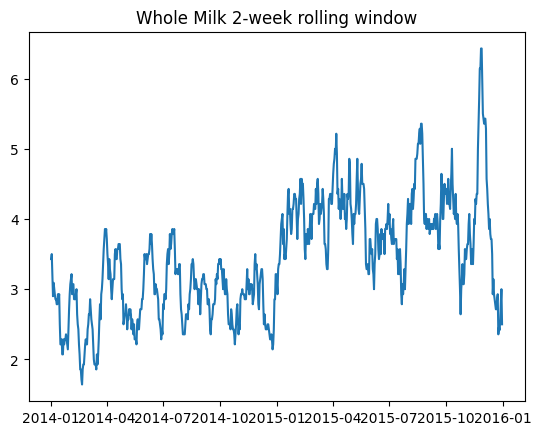

In [11]:
whole_milk_groceries = process_data_for_item_type(itemEncoderDict, groceries_data, "whole milk")
plt.plot(whole_milk_groceries[["ItemCount"]].rolling(14, center=True, min_periods=1).mean())
plt.title("Whole Milk 2-week rolling window")

I'm also using a 2-month rolling window just out of curiosity to better see if there are any large-scale seasonal patterns.

Text(0.5, 1.0, 'Whole Milk 2 month rolling window')

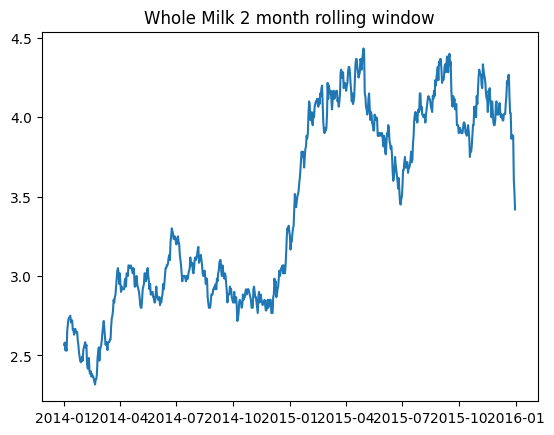

In [12]:
plt.plot(whole_milk_groceries[["ItemCount"]].rolling(60, center=True, min_periods=1).mean())
plt.title("Whole Milk 2 month rolling window")

I don't see any seasonal patterns, but we definitely see that something changes massively in 2015.

Now let's take a look at the minutiae, the weekly patterns we ignored before. To do that, I'll take a much smaller rolling window and also just look at a subsection of the 2015 data. The recent data is probably more useful to the store manager, since we want to know about our customers now, and whatever patterns there were in 2014 don't seem to be there in 2015 anymore.

In [13]:
whole_milk_2015_rolling = whole_milk_groceries.loc[whole_milk_groceries.index.year == 2015].rolling(4, center=True, min_periods=1).mean()

Text(0.5, 1.0, 'Whole Milk in 2015 (4 day rolling window)')

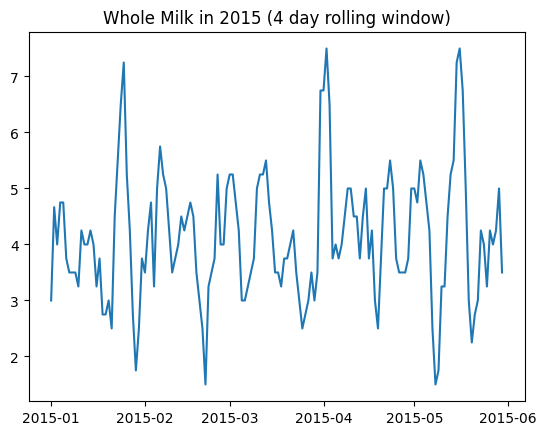

In [14]:
plt.plot(whole_milk_2015_rolling.iloc[:150])
plt.title("Whole Milk in 2015 (4 day rolling window)")

I feel like there's maybe a pattern we could pull from here. This would likely be more accurate if we knew how much whole milk each customer bought at a time (right now, the plot is just of the number of customers who bought whole milk on a given day, rather than the number of whole milk jugs bought).

In [15]:
def recover_frequencies_using_fourier(signal, time_differential=1):
    n = len(signal)
    zero_level = signal.mean()
    signal = signal - zero_level
    f_transformed = np.fft.fft(signal, n)
    
    # real and imaginary components of the transform, as well as the frequencies
    f_real = f_transformed.real
    f_imag = f_transformed.imag
    frequencies = (1/(time_differential * n)) * (np.arange(n)) # frequencies in fourier transform

    # Calculate the power spectral density (PSD)
    psd = f_transformed * np.conjugate(f_transformed) / n
    
    # We do this because the FFT is symmetric; the left half is a reflection of the right half, and we only need one half.
    frequencies = frequencies[:int(n // 2)]
    f_transformed = f_transformed[:int(n // 2)]
    psd = psd[:int(n // 2)]
    
    return frequencies, psd, f_transformed, zero_level

def get_fft_inverse(f_transformed, psd, cutoff=50):
    meets_cutoff = (psd >= cutoff).astype(int).astype(float)
    new_f_transformed = f_transformed * meets_cutoff
    inversed = np.fft.ifft(new_f_transformed)
    
    return inversed

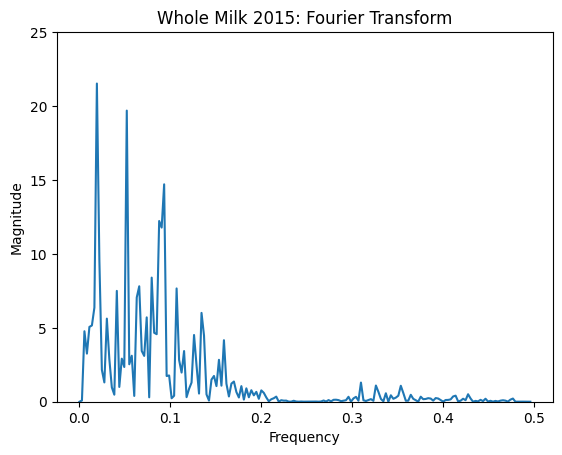

In [16]:
frequencies, psd, f_transformed, zero_level = recover_frequencies_using_fourier(whole_milk_2015_rolling["ItemCount"])

plt.plot(frequencies, psd.real)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Whole Milk 2015: Fourier Transform")
plt.ylim(0, 25)

plt.show()
plt.close()

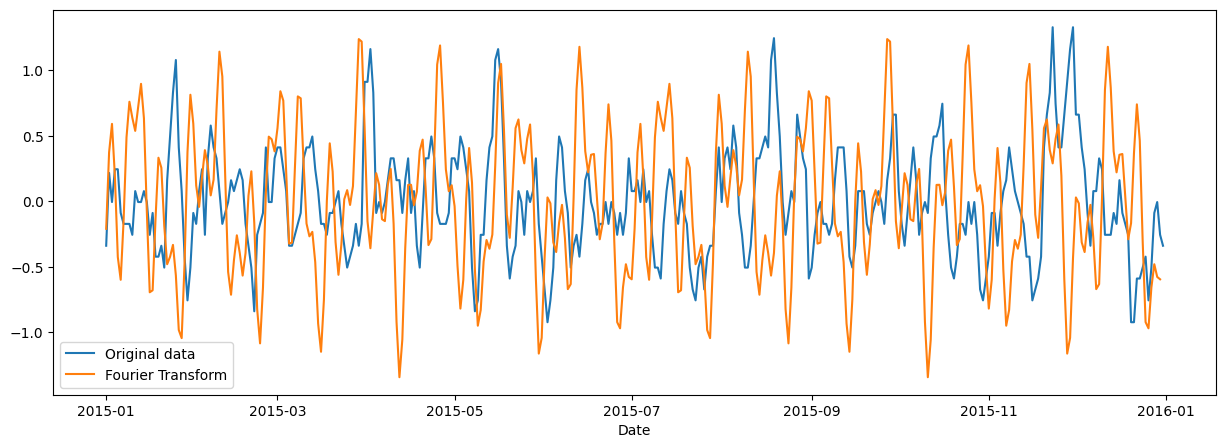

In [17]:
inversed = get_fft_inverse(f_transformed, psd, cutoff=14)
inversed = np.concatenate([inversed, inversed])

plt.figure(figsize=(15, 5))
plt.plot(whole_milk_2015_rolling.index, (whole_milk_2015_rolling["ItemCount"].values - zero_level) / 3, label="Original data")
plt.plot(whole_milk_2015_rolling.index[:len(inversed)], inversed.real, label="Fourier Transform")
plt.xlabel("Date")
plt.legend()

Well, that looks terrible. I'm not too surprised - did you notice the cutoff we had to set in the get_fft_inverse function? 14 is really low. I'd say a cutoff of 50 is the minimum for something sensible. Something as low as 19 is bound to correspond to weak frequencies. I think the really tall historical peaks around holidays (President's Day, Easter, Memorial Day, etc.) could easily also have skewed the FFT decomposition, and should be considered outlier data.

What does the lack of a cyclical pattern for whole milk mean in practical terms? It means that whole milk is a year-round staple rather than a seasonal item. This is not really a surprise to me--someone who always has milk and cereal for breakfast and always puts a splash of milk in their morning tea will probably be buying milk at a fairly constant rate.

## Concluding Thoughts on FFT

If we'd gotten a good match with the Fast Fourier Transform (FFT), we could have used that for time series predictions, but in this case, the fit is too poor for that to happen. We could also automate this process of checking each product to see if they have any FFT spikes greater than 50, i.e. any sort of cyclical aspect. If we had hordes of data on regular customers, we could focus on a specific customer who regularly buys certain items. We could look at the dates when the common pairs of items are bought, rather than just looking at each item in isolation.

There are lots of possibilities for how to use FFT, but as always, it's important to sense-check what you're doing and making sure you're not blindly trusting the results. And even if you don't get the desired outcome, you can still always learn from that experience.